# CONTROL LIBRARY EXAMPLES

# Preliminaries

In [1]:
from controlSBML.control_extensions.state_space_tf import StateSpaceTF
import controlSBML as ctl

import control
import numpy as np
import pandas as pd
import sympy
import tellurium as te
import matplotlib.pyplot as plt

# Antimony Models

## LINEAR_MDL

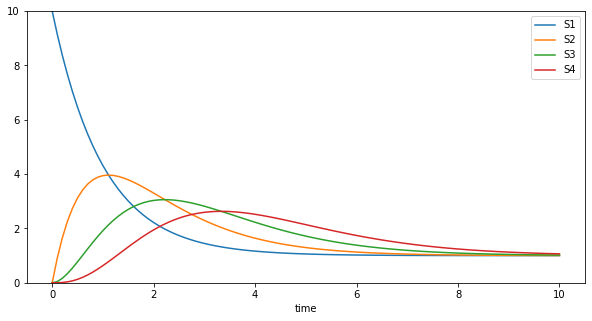

In [188]:
# Need to write the model in the correct way so that get a Jacobian with all state.
# In particular, cannot use fixed concentrations. Instead, generate the species at the same rate at which it is consumed.
LINEAR_MDL = """
J0:  -> S1; E_J0
J1: S1 -> S2; k1*S1*E_J1
J2: S2 -> S3; k2*S2*E_J2
J3: S3 -> S4; k3*S3*E_J3
J4: S4 -> $S5; k4*S4*E_J4

k1 = 1;
k2 = 1
k3 = 1
k4 = 1
S0 = 1
k0 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
S5 = 0
E_J0 = 1
E_J1 = 1
E_J2 = 1
E_J3 = 1
E_J4 = 1
"""

LINEAR_CTL = ctl.ControlSBML(LINEAR_MDL, input_names=["J0"], output_names=["S4", "S1"])
LINEAR_CTL.plotTrueModel(figsize=(10, 5), end_time=10)

In [80]:
LINEAR_CTL.roadrunner.reset()
print(LINEAR_CTL.get("J1"))
LINEAR_CTL.set({"S1": 5})
print(LINEAR_CTL.get("J1"))

10.0
5.0


In [85]:
df = LINEAR_CTL.full_stoichiometry_df
flux_ser = pd.Series({n: LINEAR_CTL.get(n) for n in df.columns})
flux_ser

J0    9.096447
J1    5.000000
J2    0.000000
J3    0.000000
J4    0.000000
dtype: float64

In [86]:
df

,J0,J1,J2,J3,J4
S1,1.0,-1.0,0.0,0.0,0.0
S2,0.0,1.0,-1.0,0.0,0.0
S3,0.0,0.0,1.0,-1.0,0.0
S4,0.0,0.0,0.0,1.0,-1.0


In [88]:
np.matmul(df.values, flux_ser.values)

array([4.09644713, 5.        , 0.        , 0.        ])

In [193]:
ctlsb = NONLINEAR_CTL
effector_dct = {"J0": "E_J0"}
def updfcn(time, x_vec, u_vec, _): 
        """ 
        Computes the change in state. This is done by having roadrunner
        calculate fluxes. No simulation is run, and so this technique
        may not always work.
        
        Parameters
        ----------
        time: float: time
        x_vec: np.array(float): state vector
        u_vec: np.array(float): input vector (in log10 units)

        Returns
        -------
        np.array(float): change in state vector
        """
        if isinstance(u_vec, float):
            u_vec = [u_vec]
        ctlsb.setTime(time)
        # Adust the state and input
        state_dct = {n: x_vec[i] for i, n in enumerate(ctlsb.state_names)}
        ctlsb.set(state_dct)
        input_dct = {effector_dct[n]: u_vec[i]
                     for i, n in enumerate(ctlsb.input_names)}
        ctlsb.set(input_dct)
        # Construct the flux vector
        s_df = ctlsb.full_stoichiometry_df
        flux_names = list(s_df.columns)
        flux_dct = {n: ctlsb.get(n) for n in flux_names}
        flux_ser = pd.Series(flux_dct)
        # Compute the change in state
        vec = np.matmul(s_df.values, flux_ser.values)
        dstate_ser = pd.Series({n: vec[i] for i, n in enumerate(s_df.index)
              if n in ctlsb.state_names})
        return dstate_ser.values

# TESTS
ctlsb.setTime(0)
x_vec = np.array(list(ctlsb.get(ctlsb.state_names).values()))
updfcn(0, x_vec, np.array([0.0]), None)

array([-100.,  100.,    0.,    0.])

In [199]:
def outfcn(time, x_vec, u_vec, _): 
        """ 
        Calculates the values of outputs.
        
        Parameters
        ----------
        time: float: time
        x_vec: np.array(float): state vector
        u_vec: np.array(float): input vector (in log10 units)

        Returns
        -------
        np.array(float): change in state vector
        """
        out_vec = np.repeat(np.nan, ctlsb.num_output)
        for out_idx, name in enumerate(ctlsb.output_names):
            state_idx = ctlsb.state_names.index(name)
            out_vec[out_idx] = x_vec[state_idx]
        if np.isnan(np.sum(out_vec)):
            raise ValueError("Outputs could not be calculated.")
        return out_vec
# Testing
ctlsb = ctl.ControlSBML(NONLINEAR_MDL, output_names=["S1", "S4", "S2"], input_names=["J0"])
time = 1
ctlsb.setTime(time)
new_x_vec = outfcn(time, ctlsb.state_ser.values, 0, None)
new_x_vec

array([1.24903456, 4.45980395, 1.41619752])

array([5., 0., 0., 0.])

In [200]:
sys = control.NonlinearIOSystem(
    updfcn, outfcn, inputs=ctlsb.input_names, outputs=ctlsb.output_names,
    states=ctlsb.state_names, name='sys')

In [201]:
ctlsb.setTime(0)
size = 101
times = np.array([n*0.1 for n in range(size)])
X0 = ctlsb.state_ser.values
U = np.repeat([10], size)
result = control.input_output_response(sys, times, X0=X0, U=U)

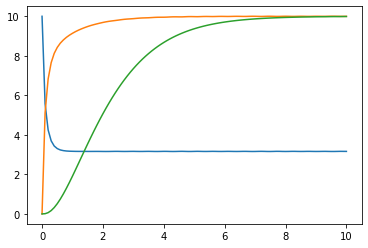

In [203]:
df = pd.DataFrame(result.outputs)
df = df.transpose()
df.columns = ctlsb.output_names
for col in df.columns:
    plt.plot(result.t, df[col])

## NONLINEAR_MDL

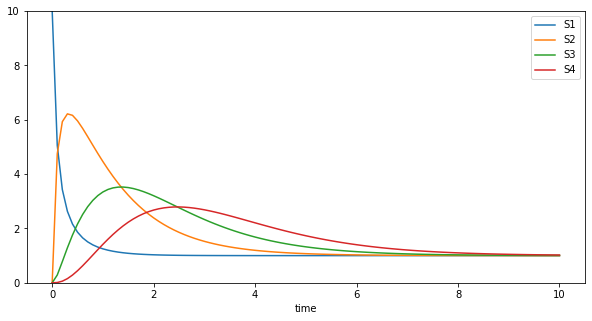

In [192]:
# Nonlinear model with one quadratic term
NONLINEAR_MDL = """
J0: -> S1; k1*E_J0
J1: S1 -> S2; k2*S1*S1
J2: S2 -> S3; k3*S2
J3: S3 -> S4; k3*S3
J4: S4 -> $S5; k4*S4

k1 = 1;
k2 = 1
k3 = 1
k4 = 1
E_J0 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
S5 = 2
"""

NONLINEAR_CTL = ctl.ControlSBML(NONLINEAR_MDL, output_names=["S1", "S4"], input_names=["J0"])
NONLINEAR_CTL.plotTrueModel(figsize=(10, 5), end_time=10, ylim=[0, 10])

# Simulation Effectors

In [4]:
length = 100
dt = 0.1
rr = LINEAR_CTL.roadrunner
rr.reset()
datas = []
for idx in range(length):
    err = 5.75 - rr["S1"]
    rr["E_J0"] += max(0, 2*err)
    #print((rr["S1"], err, rr["E_J0"], rr["J1"]))
    data = rr.simulate(idx*dt, (idx+1)*dt, 2)
    datas.append(data[0, :])
df = pd.DataFrame(np.array(datas))
df.columns = ["time", "S1", "S2", "S3", "S4"]
df = df.set_index("time")
df

,S1,S2,S3,S4
time,,,,
0.0,10.000000,0.000000,0.000000,0.000000
0.1,9.143537,0.909516,0.045397,0.001512
0.2,8.368577,1.654985,0.164895,0.010973
0.3,7.667364,2.259391,0.336968,0.033603
0.4,7.032881,2.742832,0.544182,0.072277
...,...,...,...,...
9.5,9.095488,9.087263,9.051590,8.946985
9.6,9.095579,9.088049,9.055019,8.957096
9.7,9.095661,9.088769,9.058193,8.966558


In [5]:
def common_tellurium_wrapper(time, x_vec, u_vec, params):
    """
    Calculates outputs.
    
    Parameters
    ----------
    time: float: time
    x_vec: np.array(float): state vector
    u_vec: np.array(float): input vector (in log10 units)
    params
        ctlsb: ControlSBML
        last_time: float
        is_intial: bool
            set to true for first invocation
        effector_dct: dict: Mapping of inputs to effectors
            key: input_name
            value: effector_name
    """
    # Parameter setup
    #print(("input", time, x_vec, u_vec))
    ctlsb = params.get("ctlsb", None)
    effector_dct = params.get("effector_dct", None)
    # Check if simulate
    cur_time = ctlsb.roadrunner.model.getTime()
    if params["is_initial"]:
        params["is_initial"] = False
        ctlsb.roadrunner.reset()
        params["last_time"] = 0
        state_dct = {n: x_vec[i] for i, n in enumerate(ctlsb.state_names)}
    if time - params["last_time"] < 1e-2:
        # Ignore small changes in time
        pass
    else:
        # Update the state and inputs in the simulation
        state_dct = {n: x_vec[i] for i, n in enumerate(ctlsb.state_names)}
        if not "len" in dir(u_vec):
            u_vec = [u_vec]
        input_dct = {effector_dct[n]: float(u_vec[i])
                     for i, n in enumerate(ctlsb.input_names)}
        ctlsb.set(input_dct)
        # Run the simulation
        start_time = params.get("last_time", 0)
        #print("start_time: %2.2f, end_time: %2.2f" % (start_time, time))
        _ = ctlsb.roadrunner.simulate(start_time, time, 2)
        params["last_time"] = time
    # Get the outputs
    #states = [ctlsb.get(n) for n in ctlsb.state_names]
    # return outputs
    #print(("output", ctlsb.get(ctlsb.state_names)))
    #return states

# Tests
ctlsb = ctl.ControlSBML(NONLINEAR_MDL, input_names=["J0"], output_names=["S1", "S2"])
effector_dct = {"J0": "E_J0"}
params = {"ctlsb": ctlsb, "effector_dct": effector_dct, "is_initial": True}
x_vec = ctlsb.state_ser.values
u_vec = np.repeat(1, len(ctlsb.input_names))
times = [n*0.1 for n in range(0, 51)]
times.insert(1, 1e-3)
dct = {n: [] for n in ctlsb.state_names}
for time in times:
    common_tellurium_wrapper(time, x_vec, u_vec, params)
    states = [ctlsb.get(n) for n in ctlsb.state_names]
    [dct[ctlsb.state_names[i]].append(states[i]) for i in range(ctlsb.num_state)]
    #x_vec = ctlsb.state_ser.values
df = pd.DataFrame(dct, columns=ctlsb.state_names)
df.index = times
df.index.name = "time"
# Evaluate the result
values = df.values[1:, :]
squared_error = ((ctlsb.simulateRoadrunner() - values)**2).sum().sum()
assert(squared_error < 1e-5)

In [6]:
def state_tellurium_wrapper(time, x_vec, u_vec, params):
    common_tellurium_wrapper(time, x_vec, u_vec, params)
    state_ser = params["ctlsb"].state_ser
    #print(time, state_ser)
    return state_ser.values

# Tests
state_vec = state_tellurium_wrapper(0, x_vec, u_vec, params)
state_vec = state_tellurium_wrapper(5, x_vec, u_vec, params)
assert(np.sum(state_vec) > 3)

In [7]:
def output_tellurium_wrapper(time, x_vec, u_vec, params):
    # Assume that we're just extracting state from a completed simulation
    #common_tellurium_wrapper(time, x_vec, u_vec, params)
    return params["ctlsb"].output_ser.values

# Tests
output_vec = output_tellurium_wrapper(5.0, x_vec, u_vec, params)
assert(np.sum(output_vec) < 3)

In [8]:
times = np.array([n*0.1 for n in range(0, 51)])
effector_dct = {"J0": "E_J0"}
ctlsb = ctl.ControlSBML(NONLINEAR_MDL, input_names=["J0"])
params = {"ctlsb": ctlsb, "effector_dct": effector_dct}
io_sys = control.NonlinearIOSystem(
    state_tellurium_wrapper, outfcn=output_tellurium_wrapper, states=ctlsb.state_names, 
    inputs=ctlsb.input_names, outputs=ctlsb.output_names, name='tellurium', params=params)

X0 = ctlsb.state_ser.values

# Simulate the system
results = control.input_output_response(io_sys, times, np.repeat(1, len(times)), 
                                                                    X0, params=params)

KeyError: 'is_initial'

In [ ]:
dff = pd.DataFrame(results.outputs, index=ctlsb.state_names).transpose()
dff["time"] = times
dff = dff.set_index("time")

# Constructing a Cascade of Systems

Notes
1. First create a ``NonlinearIOSystem``. Simulation is done via ``input_output_response``.
1. Eacn system, system input, system output, and system state must have a name.
1. Connections between systems are done by name
1. If there is more than one input, then you must specify the input for all time steps.
1. The number of states in the combined system is the sum of the number of states in each component system.
1. WHen specifying connections, give the input signal and then the outputs.

## Simple, Synthetic System

In [ ]:
NUM_STATE = 3
END_TIME = 10
# Create a simple system
def generateRandomState(time, x_vec, u_vec, params=None):
    num_state = len(x_vec)
    new_state = np.random.rand(num_state)
    new_state *= u_vec
    return new_state
#
state_names = ["s%d" % n for n in range(NUM_STATE)]
input_names = ["u%d" % n for n in range(NUM_STATE)]
out_sys = control.NonlinearIOSystem(generateRandomState, None, states=state_names,
                                             inputs=input_names, outputs=state_names, name="out_sys")
inp_sys = control.NonlinearIOSystem(generateRandomState, None, states=state_names,
                                             inputs=input_names, outputs=state_names, name="inp_sys")

In [ ]:
X0 = [np.random.rand(1) for _ in range(NUM_STATE)]
u_vec = np.array([np.array(np.random.rand(NUM_STATE)) for _ in  range(END_TIME)])
u_vec = np.array([np.repeat(100, NUM_STATE) for _ in  range(END_TIME)])
u_vec = np.transpose(u_vec)
times = np.array([n*0.1 for n in range(END_TIME)])
t, y = control.input_output_response(inp_sys, times, u_vec, X0)

In [ ]:
io_serial = control.interconnect(
  [inp_sys, out_sys],
  connections=[
    ['out_sys.u0', 'inp_sys.s0'],
      ['out_sys.u1', 'inp_sys.s1'],
      ['out_sys.u2', 'inp_sys.s2'],
  ],
  inplist=['inp_sys.u1', 'inp_sys.u2', 'inp_sys.u0'],
  outlist=['out_sys.s1', 'out_sys.s2', 'out_sys.s0'],
)

In [ ]:
io_serial.nstates, io_serial.noutputs, io_serial.ninputs

In [ ]:
num_state = 2*NUM_STATE
X0 = [np.random.rand(1) for _ in range(num_state)]
u_vec = np.array([np.repeat(1000, NUM_STATE) for _ in  range(END_TIME)])
u_vec = np.transpose(u_vec)
times = np.array([n*0.1 for n in range(END_TIME)])
t, y = control.input_output_response(io_serial, times, u_vec, X0)

In [ ]:
y

## ``controlSBML`` objects in systems

In [ ]:
def state_tellurium_wrapper(time, x_vec, u_vec, params):
    common_tellurium_wrapper(time, x_vec, u_vec, params)
    state_ser = params["ctlsb"].state_ser
    return state_ser.values
#
ctlsb = ctl.ControlSBML(NONLINEAR_MDL, input_names=["J0"], output_names=["S1", "S2"])
effector_dct = {"J0": "E_J0"}
params = {"ctlsb": ctlsb, "effector_dct": effector_dct}
tellurium = control.NonlinearIOSystem(state_tellurium_wrapper, output_tellurium_wrapper, states=ctlsb.state_names,
                                             inputs=ctlsb.input_names, outputs=ctlsb.output_names, name="tellurium")

In [ ]:
#inp_sys = control.NonlinearIOSystem(generateRandomState, None, states=["s1"],
#                                             inputs=["inp"], outputs=["out"], name="inp_sys")

In [ ]:
io_serial = control.interconnect(
  [tellurium, inp_sys],
  connections=[
  ['tellurium.J0', 'inp_sys.out'],
  ],
  inplist=['inp_sys.inp'],
  outlist=ctlsb.output_names,
)

In [ ]:
io_serial.connections

In [ ]:
ctlsb = ctl.ControlSBML(NONLINEAR_MDL, input_names=["J0"], output_names=["S1", "S2"])
effector_dct = {"J0": "E_J0"}
params = {"ctlsb": ctlsb, "effector_dct": effector_dct}
num_state = 1 + ctlsb.num_state
X0 = [np.random.rand(1) for _ in range(num_state)]
u_vec = np.array([1000 for _ in  range(END_TIME)])
u_vec = np.transpose(u_vec)
times = np.array([n*0.1 for n in range(END_TIME)])
t, y = control.input_output_response(io_serial, times, u_vec, X0, params=params)
df = pd.DataFrame(y, columns=ctlsb.output_names)

In [ ]:
y

In [ ]:
df = pd.DataFrame(y, index=ctlsb.output_names).T
df

# Controller Construction

In [66]:
ctlsb = ctl.ControlSBML(NONLINEAR_MDL, input_names=["J0"], output_names=["S1", "S4"])
effector_dct = {"J0": "E_J0"}
#params = {"ctlsb": ctlsb, "effector_dct": effector_dct}
#tellurium = control.NonlinearIOSystem(state_tellurium_wrapper, output_tellurium_wrapper, states=ctlsb.state_names,
#                                             inputs=ctlsb.input_names, outputs=ctlsb.output_names, name="tellurium")
tellurium = ctlsb.makeNonlinearIOSystem("tellurium", effector_dct=effector_dct)

In [71]:
xeq = [1]
global err_sum
err_sum = 0
def outfcn(t, x, u, parms):
    global err_sum
    err = 0.5(xeq - u)
    err_sum += err
def outfcn(t, x, u, parms):
    err = 1*(xeq - u)
    #print((t, err))
    return err
tellurium_control = control.NonlinearIOSystem(
  None,
  outfcn,
  inputs=['in'],
  outputs=['out'], name='control')

In [72]:
# Create the closed loop system
tellurium_closed = control.interconnect(
  [tellurium, tellurium_control],       # systems
  connections=[
    ['tellurium.J0', 'control.out'],
    ['control.in',  'tellurium.S1'],
  ],
  outlist=ctlsb.output_names,
)

In [75]:
tellurium.output_call_df

,time,state,input,params,output
0,0.000000e+00,"[0.0, 0.0, 0.0, 0.0]",[0.0],{'ctlsb': <controlSBML.control_sbml.ControlSBM...,"[0.0, 0.0]"
1,0.000000e+00,"[0.0, 0.0, 0.0, 0.0]",[1.0],{'ctlsb': <controlSBML.control_sbml.ControlSBM...,"[0.0, 0.0]"
2,1.000000e-06,"[0.0, 0.0, 0.0, 0.0]",[0.0],{'ctlsb': <controlSBML.control_sbml.ControlSBM...,"[0.0, 0.0]"
3,1.000000e-06,"[0.0, 0.0, 0.0, 0.0]",[1.0],{'ctlsb': <controlSBML.control_sbml.ControlSBM...,"[0.0, 0.0]"
4,2.000000e-07,"[0.0, 0.0, 0.0, 0.0]",[0.0],{'ctlsb': <controlSBML.control_sbml.ControlSBM...,"[0.0, 0.0]"
...,...,...,...,...,...
199,4.800000e+00,"[0.0, 0.0, 0.0, 0.0]",[1.0],{'ctlsb': <controlSBML.control_sbml.ControlSBM...,"[0.0, 0.0]"
200,4.900000e+00,"[0.0, 0.0, 0.0, 0.0]",[0.0],{'ctlsb': <controlSBML.control_sbml.ControlSBM...,"[0.0, 0.0]"
201,4.900000e+00,"[0.0, 0.0, 0.0, 0.0]",[1.0],{'ctlsb': <controlSBML.control_sbml.ControlSBM...,"[0.0, 0.0]"
202,5.000000e+00,"[0.0, 0.0, 0.0, 0.0]",[0.0],{'ctlsb': <controlSBML.control_sbml.ControlSBM...,"[0.0, 0.0]"


In [73]:
tellurium.reset()
size = 51
times = np.array([n*0.1 for n in range(size)])
X0 = ctlsb.state_ser.values
U = np.repeat(1, size)
U = np.reshape(np.array([]), (0, 51))
t, y = control.input_output_response(tellurium_closed, times, U, X0, params=params)
#t, y = control.input_output_response(tellurium, times, U, X0)
df = pd.DataFrame(np.transpose(y), columns=ctlsb.output_names)
df

,S1,S4
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


# Predatory Prey

In [41]:
def predprey_rhs(t, x, u, params):
    # Parameter setup
    a = params.get('a', 3.2)
    b = params.get('b', 0.6)
    c = params.get('c', 50.)
    d = params.get('d', 0.56)
    k = params.get('k', 125)
    r = params.get('r', 1.6)

    # Map the states into local variable names
    H = x[0]
    L = x[1]

    # Compute the control action (only allow addition of food)
    u_0 = u if u > 0 else 0

    # Compute the discrete updates
    dH = (r + u_0) * H * (1 - H/k) - (a * H * L)/(c + H)
    dL = b * (a * H *  L)/(c + H) - d * L

    return [dH, dL]

In [44]:
io_predprey = control.NonlinearIOSystem(
    predprey_rhs, None, inputs=('u'), outputs=('H', 'L'),
    states=('H', 'L'), name='predprey')

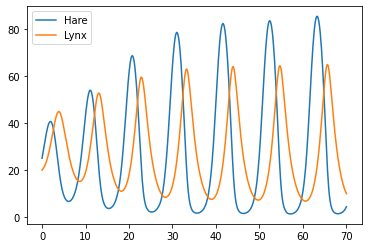

In [45]:
# Simulate the system
X0 = [25, 20]                 # Initial H, L
T = np.linspace(0, 70, 500)   # Simulation 70 years of time

# Simulate the system
t, y = control.input_output_response(io_predprey, T, 0, X0)

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Hare', 'Lynx'])
plt.show(block=False)

In [ ]:
np.shape(T)

In [46]:
# Create a feedback controller. Step 1: Find an equalibrium point
eqpt = control.find_eqpt(io_predprey, X0, 0)
xeq = eqpt[0]                         # choose the nonzero equilibrium point
lin_predprey = control.linearize(io_predprey, xeq, 0)

/home/ubuntu/controlSBML/ctl/lib/python3.6/site-packages/control/iosys.py:1007: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [48]:
# Step 2: Construct the controller via pole placement
K = control.place(lin_predprey.A, lin_predprey.B, [-0.1, -0.2])
A, B = lin_predprey.A, lin_predprey.B
C = np.array([[0, 1]])                # regulated output = number of lynxes
kf = -1/(C @ np.linalg.inv(A - B @ K) @ B)

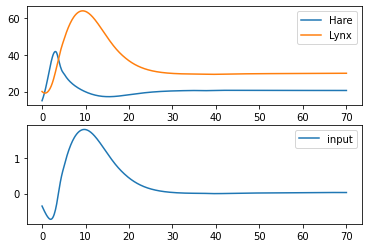

In [49]:
# Construct the controller
io_controller = control.NonlinearIOSystem(
  None,
  lambda t, x, u, params: -K @ (u[1:] - xeq) + kf * (u[0] - xeq[1]),
  inputs=('Ld', 'u1', 'u2'), outputs=1, name='control')

# Create the closed loop system
io_closed = control.interconnect(
  [io_predprey, io_controller],       # systems
  connections=[
    ['predprey.u', 'control.y[0]'],
    ['control.u1',  'predprey.H'],
    ['control.u2',  'predprey.L']
  ],
  inplist=['control.Ld'],
  outlist=['predprey.H', 'predprey.L', 'control.y[0]']
)

# Simulate the system
t, y = control.input_output_response(io_closed, T, 30, [15, 20])

# Plot the response
plt.figure(2)
plt.subplot(2, 1, 1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Hare', 'Lynx'])
plt.subplot(2, 1, 2)
plt.plot(t, y[2])
plt.legend(['input'])
plt.show(block=False)

In [ ]:
# Construct the controller
io_controller = control.NonlinearIOSystem(
  None,
  lambda t, x, u, params: -K @ (u[1:] - xeq) + kf * (u[0] - xeq[1]),
  inputs=('Ld', 'u1', 'u2'), outputs=1, name='control')

In [ ]:
# Create the closed loop system
io_closed = control.interconnect(
  [io_predprey, io_controller],       # systems
  connections=[
    ['predprey.u', 'control.y[0]'],
    ['control.u1',  'predprey.H'],
    ['control.u2',  'predprey.L']
  ],
  inplist=['control.Ld'],
  outlist=['predprey.H', 'predprey.L', 'control.y[0]']
)

In [ ]:
# Simulate the system
t, y = control.input_output_response(io_closed, T, 30, [15, 20])

# Plot the response
plt.figure(2)
plt.subplot(2, 1, 1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Hare', 'Lynx'])
plt.subplot(2, 1, 2)
plt.plot(t, y[2])
plt.legend(['input'])
plt.show(block=False)

# Vertial Takeoff and Landing: TF + Bode plots

In [ ]:
# pvtol-nested.py - inner/outer design for vectored thrust aircraft
# RMM, 5 Sep 09
#
# This file works through a fairly complicated control design and
# analysis, corresponding to the planar vertical takeoff and landing
# (PVTOL) aircraft in Astrom and Murray, Chapter 11.  It is intended
# to demonstrate the basic functionality of the python-control
# package.
#

import os
import matplotlib.pyplot as plt  # MATLAB plotting functions
from control.matlab import *    # MATLAB-like functions
import numpy as np

# System parameters
m = 4               # mass of aircraft
J = 0.0475          # inertia around pitch axis
r = 0.25            # distance to center of force
g = 9.8             # gravitational constant
c = 0.05            # damping factor (estimated)

# Transfer functions for dynamics
Pi = tf([r], [J, 0, 0])  # inner loop (roll)
Po = tf([1], [m, c, 0])  # outer loop (position)

#
# Inner loop control design
#
# This is the controller for the pitch dynamics.  Goal is to have
# fast response for the pitch dynamics so that we can use this as a
# control for the lateral dynamics
#

# Design a simple lead controller for the system
k, a, b = 200, 2, 50
Ci = k*tf([1, a], [1, b])  # lead compensator
Li = Pi*Ci

# Bode plot for the open loop process
plt.figure(1)
bode(Pi)

# Bode plot for the loop transfer function, with margins
plt.figure(2)
bode(Li)

# Compute out the gain and phase margins
#! Not implemented
# gm, pm, wcg, wcp = margin(Li)

# Compute the sensitivity and complementary sensitivity functions
Si = feedback(1, Li) 
Ti = Li*Si

# Check to make sure that the specification is met 
plt.figure(3)
gangof4(Pi, Ci) 

# Compute out the actual transfer function from u1 to v1 (see L8.2 notes)
# Hi = Ci*(1-m*g*Pi)/(1+Ci*Pi)
Hi = parallel(feedback(Ci, Pi), -m*g*feedback(Ci*Pi, 1)) 

plt.figure(4)
plt.clf()
plt.subplot(221)
bode(Hi)

# Now design the lateral control system
a, b, K = 0.02, 5, 2
Co = -K*tf([1, 0.3], [1, 10])  # another lead compensator
Lo = -m*g*Po*Co                                                                                                                        

# State Space to Transfer Function

``ss2tf`` does the conversion from state space model to transfer function for a single input, single output system.
Conceptually, this is done by a similarity transformation in which the ${\bf A}$ matrix is restructured into the "controlability" form: (a) the first row has a leading 1; (b) row $n > 1$ has its only non-zero column as $n + 1$. That is, the new state variables are $x_{n+1} = \dot{x}_n$. If the matrix is singular, then some rows are zero. From this, it is easy to construct a transfer function.

In [ ]:
A_mat = [[1., -2], [3, -4]]
B_mat = np.identity(2)
C_mat = np.identity(2)
D_mat = 0*np.identity(2)
sys_mimo = StateSpace(A_mat, B_mat, C_mat, D_mat)
sys1 = ss2tf(sys_mimo)
sys1

In [ ]:
s = sympy.symbols("s")

In [ ]:
#A_mat = np.random.randint(0, 10, (size, size))
size= np.shape(A_mat)[0]
smat = sympy.eye(size) *s - sympy.Matrix(A_mat)
smat.inv()

In [ ]:
ss_tf = StateSpaceTF(sys_mimo)
print(ss_tf)

In [ ]:
ss_tf.plotBode(legend_crd=(1.2, 1))

In [ ]:
func11 = lambda s: 20*np.log10(np.abs( (s+4)/(s**2 + 3*s + 2)))
func12 = lambda s: 20*np.log10(np.abs( (-2)/(s**2 + 3*s + 2)))
func21 = lambda s: 20*np.log10(np.abs( (3)/(s**2 + 3*s + 2)))
func22 = lambda s: 20*np.log10(np.abs( (s - 1)/(s**2 + 3*s + 2)))
for f in [func11, func12, func21, func22]:
    print(f(0.1))

In [ ]:
_ = control.bode(ss_tf.dataframe.loc["2", "2"])

In [ ]:
A = [[1., -2], [3, -4]]
B = [[5.], [7]]
C = [[6., 8]]
D = [[9.]]
sys2 = ss2tf(A, B, C, D)
sys2

In [ ]:
sys = control.StateSpace(A, B, C, D)
sys

In [ ]:
_ = bode(sys[0, 0])

In [ ]:
tf = ss2tf(sys)

One description of a MIMO system is the matrix of input, output transfer functions. Another is to diagonlize the system.

In [ ]:
tf.frequency_response(np.pi)


In [ ]:
mag, phase, angle = control.freqresp(sys1, [0.1*v for v in range(1, 101)])
plt.plot(np.log10(angle), 20*np.log10(mag[0][0,:]))
plt.plot(np.log10(angle), 20*np.log10(mag[0][1,:]))

In [ ]:
plt.plot(angle, mag[0][1,:])

In [ ]:
sys = control.TransferFunction(tf[0, 0])
ax = plt.subplots(1)
mag, phase, angle = bode(sys, [0.1*v for v in range(1, 10000)])

In [ ]:
20*np.log10(mag)

In [ ]:
angle

# Explore

In [ ]:
arr = np.array(range(5))
arr1 = np.array(arr)
arr1[0] = 2
arr, arr1

In [ ]:
bode(